In [1]:
!pip install -U tensorflow-text==2.6.0

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from transformers import BertTokenizer
from transformers import TFBertModel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.5 MB/s eta 0:00:00:00:010:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 27.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 14.8 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77041 sha256=5879d30e7474dbf23ef9851b3d90e3c9d11ebd7732c585a9a0de118e21a1e9e8
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.1
    Uninstalling wrapt-1.14.1:
      Successfully uninstalled wrapt-1.14.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installatio

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
print(tokenizer.encode('My name is AbdulBasit',add_special_tokens=True,max_length=60))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 2026, 2171, 2003, 10298, 22083, 4183, 102]


In [4]:
print(tf.__version__)

2.6.4


In [5]:
label_map={'people':0, 'rescue':1, 'No Human':2}

In [6]:
train_df=pd.read_csv('../input/datatask4/train-task4-annotated.csv')

In [7]:
train_df['image_path']=train_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/'+x)
train_df['human_id']=train_df['human_class'].apply(lambda x: label_map[x])


In [8]:
test_df=pd.read_csv('../input/datatask4/test-new-task4-annotated.csv')
test_df['image_path']=test_df.image_path.apply(lambda x: f'../input/crisismmd/CrisisMMD_v2.0/'+x)
test_df['human_id']=test_df['human_class'].apply(lambda x: label_map[x])
delete=[]
for idx,row in test_df.iterrows():
    if type(row['preprocess_tweet_text'])==float:
        test_df.at[idx,'preprocess_tweet_text']=' '
#test_df.drop(delete,inplace=True)
test_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path,preprocess_tweet_text,human_class,human_id
0,5514,5514,921754220407263237,921754220407263237_2,not_informative,0.6844,not_informative,1.0000,not_humanitarian,0.6844,not_humanitarian,1.0000,NaN,NaN,Who's joining us this weekend for the final da...,http://pbs.twimg.com/media/DMq6k7yVwAEGfl5.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,who joining us this weekend for the final days...,No Human,2
1,8749,8749,904667830955724800,904667830955724800_0,informative,0.6450,informative,1.0000,rescue_volunteering_or_donation_effort,0.6450,rescue_volunteering_or_donation_effort,1.0000,NaN,NaN,#ByTheNumbers #USArmy Soldiers and equipment s...,http://pbs.twimg.com/media/DI1sH9XXcAEe1Ip.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,bythenumbers usarmy soldiers and equipment su...,rescue,1
2,8069,8069,901804808105066496,901804808105066496_0,informative,0.3447,informative,0.3426,infrastructure_and_utility_damage,0.3447,affected_individuals,0.3426,NaN,NaN,This is David Strauss. He saw a red SUV get st...,http://pbs.twimg.com/media/DIParV3UEAQHIwD.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,this is david strauss he saw red suv get stuck...,people,0
3,16215,16215,910187280329007104,910187280329007104_0,not_informative,0.6396,not_informative,0.6598,not_humanitarian,0.6396,not_humanitarian,0.6598,NaN,NaN,"After Irma, I'm wondering if Florida should st...",http://pbs.twimg.com/media/DKGigVxXcAEQvZE.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,after irma wondering if florida should still b...,No Human,2
4,429,429,918276885519331328,918276885519331328_0,informative,0.6934,not_informative,1.0000,other_relevant_information,0.6934,not_humanitarian,1.0000,NaN,NaN,Air pollution due to #wildfires in #California...,http://pbs.twimg.com/media/DL5f9NuVQAA7rn0.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/c...,air pollution due to wildfires in california i...,No Human,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,8457,8457,904410103050366976,904410103050366976_0,informative,0.6393,informative,1.0000,infrastructure_and_utility_damage,0.6393,infrastructure_and_utility_damage,1.0000,severe_damage,1.0,RT @kimbpix: View from bridge into orange from...,http://pbs.twimg.com/media/DI0axjmV4AAuJyk.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,view from bridge into orange from bridge city...,No Human,2
2709,15790,15790,910117010511712257,910117010511712257_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,Tropical Storm Maria is likely to reach hurric...,http://pbs.twimg.com/media/DKFimQMWsAAxZ1A.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,tropical storm maria is likely to reach hurric...,No Human,2
2710,8021,8021,901776018863779840,901776018863779840_0,informative,0.6449,informative,0.6493,other_relevant_information,0.6449,other_relevant_information,0.6493,NaN,NaN,RT @KOCOBrad: Rain totals from #Harvey across ...,http://pbs.twimg.com/media/DIO-QAaVAAACw-W.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,rain totals from harvey across the houston ar...,No Human,2
2711,2002,2002,872022117574770689,872022117574770689_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,not_humanitarian,1.0000,NaN,NaN,#INSSumitra arrives in #Yangon bearing assista...,http://pbs.twimg.com/media/DBoLdplU0AAuoxq.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,inssumitra arrives in yangon bearing atance f...,rescue,1


In [9]:
delete=[]
for idx,row in train_df.iterrows():
    if type(row['preprocess_tweet_text'])==float:
        train_df.at[idx,'preprocess_tweet_text']=' '
        #delete.append(idx)
#train_df.drop(delete,inplace=True)

In [10]:
train_df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path,preprocess_tweet_text,human_class,human_id
0,3571,3571,912156245032882179,912156245032882179_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,A gas station worker fills a jug with gasoline...,http://pbs.twimg.com/media/DKig9BTU8AAmWQy.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,gas station worker fills jug with gasoline fo...,No Human,2
1,2320,2320,876523585078255618,876523585078255618_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,A docu-series by Rick Mora visiting Native Ame...,http://pbs.twimg.com/media/DCoJjGgWsAEJV0u.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/s...,docu series by rick mora visiting native amer...,No Human,2
2,15998,15998,910150747228172288,910150747228172288_0,informative,0.6934,informative,1.0000,infrastructure_and_utility_damage,0.6934,infrastructure_and_utility_damage,1.0000,mild_damage,0.6262,FPL throws some shade on a city‚Äôs threat to ...,http://pbs.twimg.com/media/DKGBReVWkAAoYJ9.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,fpl throws some shade on city threat to sue ov...,No Human,2
3,966,966,920353785892999169,920353785892999169_0,informative,1.0000,informative,0.3894,affected_individuals,1.0000,infrastructure_and_utility_damage,0.3894,severe_damage,1.0000,Vallejo family fighting wildfires on two front...,http://pbs.twimg.com/media/DMXA43iX0AAs-vl.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/c...,vallejo family fighting wildfires on two front...,people,0
4,8594,8594,904508316579225601,904508316579225601_2,not_informative,0.6623,not_informative,1.0000,not_humanitarian,0.6623,not_humanitarian,1.0000,NaN,NaN,https://t.co/n8ZhxlNpb9 Get your daily deals h...,http://pbs.twimg.com/media/DI11hA0XkAIH0b4.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,,No Human,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15364,11233,11233,907779904254734341,907779904254734341_0,informative,1.0000,informative,1.0000,infrastructure_and_utility_damage,1.0000,infrastructure_and_utility_damage,1.0000,severe_damage,0.7703,Possible tornado destroys condo buildings in C...,http://pbs.twimg.com/media/DJkVAFIW0AY-n8s.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,possible tornado destroys condo buildings in c...,No Human,2
15365,12231,12231,905625434955673601,905625434955673601_0,informative,0.6867,not_informative,0.6609,other_relevant_information,0.6867,not_humanitarian,0.6609,NaN,NaN,RT @MiamiHerald: Brickell residents aren’t tak...,http://pbs.twimg.com/media/DJFPTQZWAAAm0XX.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,brickell residents aren,No Human,2
15366,5567,5567,921808746959048704,921808746959048704_0,informative,0.3461,informative,0.6461,other_relevant_information,0.3461,rescue_volunteering_or_donation_effort,0.6461,NaN,NaN,Come by the Spanish Club table to support Puer...,http://pbs.twimg.com/media/DMrsJOdWkAEjtQF.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,come by the spanish club table to suppo pueo r...,rescue,1
15367,11865,11865,908930940029857792,908930940029857792_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,"Guys, NEW ARTICLE OUT NOWá½„6á½„6á½„6LINK IS I...",http://pbs.twimg.com/media/DJ0r2z4WAAU6F0K.jpg,../input/crisismmd/CrisisMMD_v2.0/data_image/h...,guys new aicle out now 6 6 6link is in the bio...,No Human,2


In [11]:
train_df['tokenised_text']=train_df['preprocess_tweet_text'].apply(lambda x:tokenizer.encode(x, add_special_tokens=True, max_length=60) )

In [12]:
test_df['tokenised_text']=test_df['preprocess_tweet_text'].apply(lambda x:tokenizer.encode(x, add_special_tokens=True, max_length=60) )

In [13]:
max_len = 60
#input_ids_train=[]
#for i in train_df['tokenised_text'].values:
#    input_ids_train.append(tf.constant(i+[0]*(max_len-len(i))))
input_ids_train= np.array([i + [0]*(max_len-len(i)) for i in train_df['tokenised_text'].values])
attention_mask_train= np.where(input_ids_train!= 0, 1, 0)
'''attention_mask_train=[]
for row in input_ids_temp:
    temp=[]
    for val in row:
        if val!=0:
            temp.append(1)
        else:
            temp.append(0)
    attention_mask_train.append(tf.constant(temp))'''

'attention_mask_train=[]\nfor row in input_ids_temp:\n    temp=[]\n    for val in row:\n        if val!=0:\n            temp.append(1)\n        else:\n            temp.append(0)\n    attention_mask_train.append(tf.constant(temp))'

In [14]:
max_len = 60
input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in test_df['tokenised_text'].values])
attention_mask_test= np.where(input_ids_test!= 0, 1, 0)

In [15]:
def dataframe_to_dataset(dataframe,input_ids,attention_mask,training=True):
    columns = ["image_path", "human_id"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("human_id")
    label_array=[]
    for i in labels:
        temp=[0,0,0]
        temp[i]=1
        label_array.append(temp)
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'],input_ids,attention_mask, label_array))
    if training:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [20]:
resize = (224, 224)


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]
    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

'''
def preprocess_text(text_1):
    text_1 = tf.convert_to_tensor([text_1])
    output = bert_preprocess_model(text_1)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output'''


def preprocess_text_and_image(sample,input_ids,attention_mask):
    image_1 = preprocess_image(sample)
    text_1={
        'input_ids':input_ids,
        'attention_mask':attention_mask
    }
    return {"image": image_1, "text": text_1}
def make_label_dict(label_damage,label_structure):
    return {'damage':label_damage,'structure':label_structure}
def make_sample_weight_dict(damage,structure):
    return {'damage':damage,'structure':structure}

In [21]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe,input_ids,attention_mask, training=True):
    ds = dataframe_to_dataset(dataframe,input_ids,attention_mask,training)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x,input_ids,attention_mask,y : (preprocess_text_and_image(x,input_ids,attention_mask),y))
    ds = ds.batch(batch_size)
    return ds


train_ds = prepare_dataset(train_df,input_ids_train,attention_mask_train)


In [22]:
test_ds = prepare_dataset(test_df,input_ids_test,attention_mask_test,training=False)


In [23]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [24]:
deit=tf.keras.models.load_model('../deit-distilled')
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    # Set the trainability of the base encoder.
    
    # Receive the images as inputs.
    deit.trainable=False
    image_1 = keras.Input(shape=(224, 224 ,3), name="image")
    x = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')(image_1)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x=tf.keras.layers.RandomHeight(factor=0.1)(x)
    x=tf.keras.layers.RandomWidth(0.1)(x)
    x = tf.keras.layers.RandomZoom(0.2)(x)
    # Preprocess the input image.
    preprocessed_1=keras.applications.resnet_v2.preprocess_input(x)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1= deit(preprocessed_1)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings_1, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image_1, outputs, name="vision_encoder")

242761728/242745792 [==============================] - 1s 0us/step


In [25]:
bert=TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_ids", "attention_mask"]
    inputs = {
        feature: keras.Input(shape=(60,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert.bert(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0][:,0,:]
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    # Project the embeddings produced by the model.
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


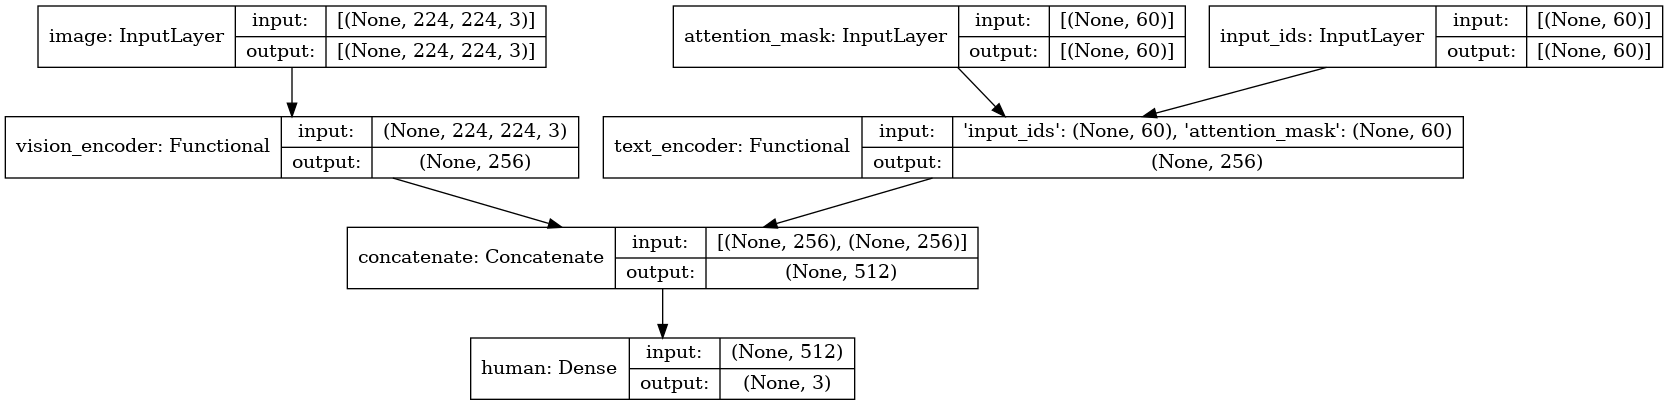

In [26]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_ids", "attention_mask"]
    text_inputs = {
        feature: keras.Input(shape=(60,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, 256, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, 256, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_1)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    human = keras.layers.Dense(3, activation="softmax",name='human')(concatenated)
    return keras.Model([image_1, text_inputs], human)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [27]:
multimodal_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
vision_encoder (Functional)     (None, 256)          60703208    image[0][0]                      
______________________________________________________________________________________________

In [ ]:
tf.get_logger().setLevel('INFO')
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(amsgrad=True), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics
)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-recall-inception-bert', monitor='recall', mode='max', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valrecall-inception-bert', monitor='val_recall', mode='max', save_best_only=True)
callbacks_list = [es, mc,ms] #early
class_weights={0:10.97,1:4.02,2:1.515}
history = multimodal_model.fit(train_ds, validation_data=test_ds, epochs=100,callbacks=callbacks_list)

In [38]:
model=keras.models.load_model('./best_model_alt-valrecall-inception-bert')

In [48]:
predict=multimodal_model.predict(test_ds)
print(predict)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


[[9.5020705e-06 1.7819554e-02 9.8217094e-01]
 [3.8942864e-05 4.6485275e-04 9.9949622e-01]
 [2.8926877e-03 3.0566216e-04 9.9680161e-01]
 ...
 [3.2641676e-06 1.0760471e-03 9.9892068e-01]
 [1.6366725e-04 1.3645240e-05 9.9982268e-01]
 [6.3956257e-05 1.1270224e-03 9.9880898e-01]]


In [49]:
damage_predict=predict
damage_prediction=[]

for row in damage_predict:
    damage_prediction.append(np.argmax(row))

In [50]:
real_damage=test_df['human_id']

In [51]:
from sklearn import metrics
print(metrics.classification_report(real_damage,damage_prediction))
print(metrics.confusion_matrix(real_damage,damage_prediction))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       339
           1       0.83      0.88      0.85       767
           2       0.92      0.92      0.92      1794

    accuracy                           0.88      2900
   macro avg       0.85      0.84      0.84      2900
weighted avg       0.88      0.88      0.88      2900

[[ 244   34   61]
 [  15  672   80]
 [  50   99 1645]]


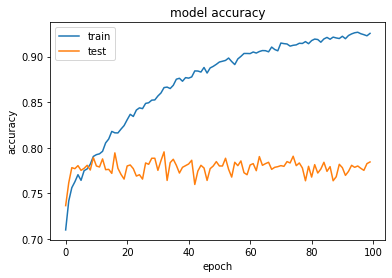

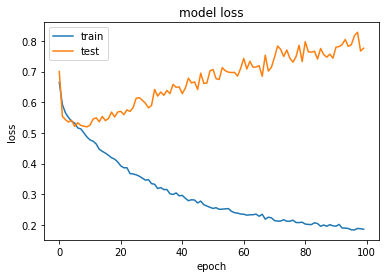

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
import shutil
shutil.make_archive('best_model_alt-recall-deit-bert', 'zip', './best_model_alt-recall-inception-bert')
shutil.make_archive('best_model_alt-valrecall-deit-bert', 'zip', './best_model_alt-valrecall-inception-bert')

'/kaggle/working/best_model_alt-valrecall-deit-bert.zip'

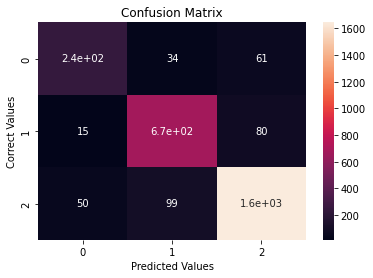

In [54]:
import seaborn as sns
cm = metrics.confusion_matrix(real_damage, damage_prediction)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()